In [41]:
#Why ResNet
#ResNet (Residual Networks) is a type of CNN architecture that addresses the problem of vanishing gradients, which occurs when training very deep networks. 
#ResNet introduces the concept of residual connections, which allow gradients to flow more easily through the network by bypassing multiple layers
#ResNet allows for much deeper networks (with hundreds or even thousands of layers) to be trained effectively, while traditional CNNs start to have diminishing returns in performance as the depth increases.
#ResNet reduces the training time and the risk of overfitting by allowing the network to learn the residual mapping between the input and the output of each layer, instead of learning the full mapping.


In [42]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset

import pandas as pd
import time
import numpy as np
import matplotlib.pylab as plt
import cv2

In [2]:
# Load the .csv file into a Pandas DataFrame
df_training = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/train.csv')
df_training

,id,image,classification
0,0,2_000000.png,7
1,1,0_000001.png,2
2,2,1_000002.png,7
3,3,3_000003.png,4
4,4,1_000004.png,3
...,...,...,...
239995,239995,2_239995.png,4
239996,239996,1_239996.png,5
239997,239997,3_239997.png,7
239998,239998,3_239998.png,1


In [3]:
#image_list = []
image = df_training['image'].to_list()
labels = df_training['classification'].to_list()


In [4]:
zero = np.zeros((240000,28,28),dtype=np.uint8) 

In [5]:
for i in range(240000):
    zero[i] = cv2.imread(f'dataset/train/{labels[i]}/{image[i]}',0)

In [6]:
zero = zero/255 #normalizing data

In [7]:
images = torch.tensor(zero).reshape((240000,1,28,28)).float() #wait convert from numpy array into torch tensor with shape(240000,1,28,28)

In [8]:
classes = torch.tensor(labels)
classes = classes.type(torch.LongTensor)

In [9]:
classes

tensor([7, 2, 7,  ..., 7, 1, 8])

In [13]:
class ImageLabelDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return (image, label)


training_set = ImageLabelDataset(images, classes)

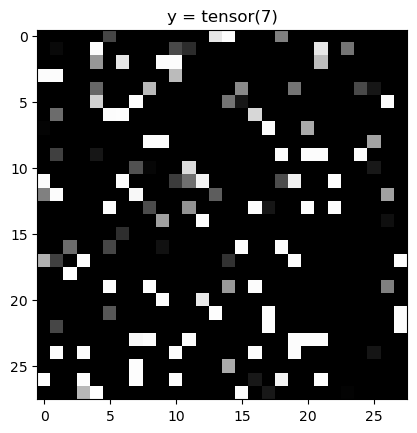

In [14]:
def shows_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
shows_data(training_set[0])

In [27]:
# Hyperparameters
random_seed = 123
learning_rate = 0.001
num_epochs = 1
batch_size = 256

# Architecture
num_classes = 10

In [16]:
train_loader = DataLoader(training_set, batch_size=256, shuffle=True)

In [43]:
class ResidualBlock(torch.nn.Module):
    

    def __init__(self, channels):
        
        super(ResidualBlock, self).__init__()
        
        self.block = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[1],
                                kernel_size=(3, 3),
                                stride=(2, 2),
                                padding=1),
                torch.nn.BatchNorm2d(channels[1]),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=channels[1],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=0),   
                torch.nn.BatchNorm2d(channels[2])
        )

        self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=(2, 2),
                                padding=0),
                torch.nn.BatchNorm2d(channels[2])
        )
            
    def forward(self, x):
        shortcut = x
        
        block = self.block(x)
        shortcut = self.shortcut(x)    
        x = torch.nn.functional.relu(block+shortcut)

        return x
#This code defines a Pytorch neural network module called 'ResidualBlock' that consists of two parts: a "block" and a "shortcut" connection. The block is a sequence of two convolutional layers, batch normalization, and a ReLU activation. The shortcut connection is a single convolutional layer and batch normalization. The forward function of the module applies the block to the input, applies the shortcut connection to the input, and then adds the two results together and applies a ReLU activation. The overall effect of this architecture is to allow the network to learn an identity mapping (i.e., the residual) in addition to the normal mapping. This can help the network to converge faster and improve performance on some tasks.

In [19]:
#Model

class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        self.residual_block_1 = ResidualBlock(channels=[1, 4, 8])
        self.residual_block_2 = ResidualBlock(channels=[8, 16, 32])
        self.residual_block_3 = ResidualBlock(channels=[32, 64, 128])
        
        self.linear_1 = torch.nn.Linear(2048, 684) 
        self.linear_2 = torch.nn.Linear(684, 256)
        self.linear_3 = torch.nn.Linear(256, 128)
        self.linear_4 = torch.nn.Linear(128, 64)
        self.linear_5 = torch.nn.Linear(64, num_classes)
        
    def forward(self, x):

        out = self.residual_block_1(x)
        out = self.residual_block_2(out)
        out = self.residual_block_3(out)
        
        logits = self.linear_1(out.view(-1, 2048))
        logits = torch.relu(logits)
        logits = self.linear_2(logits)
        logits = torch.relu(logits)
        logits = self.linear_3(logits)
        logits = torch.relu(logits)
        logits = self.linear_4(logits)
        logits = torch.relu(logits)
        logits = self.linear_5(logits)
        return logits
#This code defines a Pytorch neural network module called 'ConvNet' that is composed of three instances of the previously defined 'ResidualBlock' module, followed by a series of linear layers and ReLU activation functions.
#The 'ConvNet' takes an input tensor 'x' and applies the 'ResidualBlock_1' , 'ResidualBlock_2' and 'ResidualBlock_3' in sequence. The output of each block is passed as input to the next block. The output from the last 'ResidualBlock' is then passed through a series of linear layers which are fully connected layers that map the input to output. The output of the last linear layer is the final output of the model and is returned by the forward function. The number of classes that the model is designed to predict is passed as an argument to the constructor and is used in the last linear layer to determine the number of output units.
    
torch.manual_seed(random_seed)
model = ConvNet(num_classes=num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [23]:
loss_list = []
print_interval = 1

for epoch in range(num_epochs):
    start_time = time.time()
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        
            
        #FORWARD AND BACK PROP
        logits = model(features)
        cost = torch.nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        # UPDATE MODEL PARAMETERS
        optimizer.step()
        loss_list.append(cost.data.item())
        
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(training_set)//batch_size, cost))
    elapsed_time = time.time() - start_time
    print('Elapsed time for epoch {}: {:.2f} seconds'.format(epoch+1, elapsed_time))
    if epoch % print_interval == 0:
            print(f'Epoch {epoch}: Loss = {cost.data.item():.4f}')


Epoch: 001/020 | Batch 000/7500 | Cost: 0.0851
Epoch: 001/020 | Batch 050/7500 | Cost: 0.3366
Epoch: 001/020 | Batch 100/7500 | Cost: 0.0397
Epoch: 001/020 | Batch 150/7500 | Cost: 0.0373
Epoch: 001/020 | Batch 200/7500 | Cost: 0.0061
Epoch: 001/020 | Batch 250/7500 | Cost: 0.0351
Epoch: 001/020 | Batch 300/7500 | Cost: 0.1038
Epoch: 001/020 | Batch 350/7500 | Cost: 0.0792
Epoch: 001/020 | Batch 400/7500 | Cost: 0.0170
Epoch: 001/020 | Batch 450/7500 | Cost: 0.9102
Epoch: 001/020 | Batch 500/7500 | Cost: 0.0582
Epoch: 001/020 | Batch 550/7500 | Cost: 0.0013
Epoch: 001/020 | Batch 600/7500 | Cost: 0.0653
Epoch: 001/020 | Batch 650/7500 | Cost: 0.1078
Epoch: 001/020 | Batch 700/7500 | Cost: 0.0059
Epoch: 001/020 | Batch 750/7500 | Cost: 0.0499
Epoch: 001/020 | Batch 800/7500 | Cost: 0.0334
Epoch: 001/020 | Batch 850/7500 | Cost: 0.0471
Epoch: 001/020 | Batch 900/7500 | Cost: 0.0576
Epoch: 001/020 | Batch 950/7500 | Cost: 0.1378
Epoch: 001/020 | Batch 1000/7500 | Cost: 0.0611
Epoch: 001/0

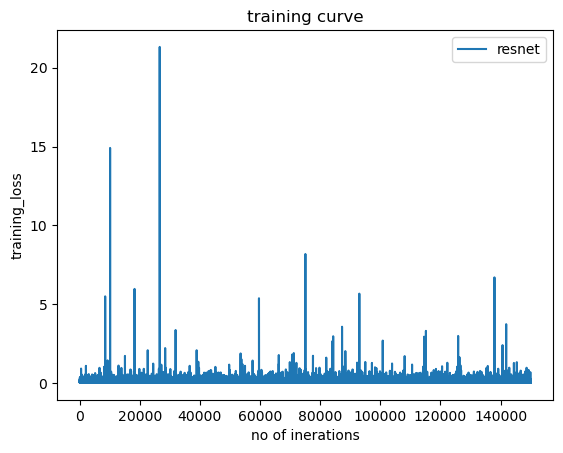

In [24]:
# Compare the training loss

plt.plot(loss_list, label='resnet')
plt.ylabel('training_loss')
plt.xlabel('no of inerations')
plt.title('training curve')
plt.legend()
plt.show()

In [20]:
df_test = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/test.csv')

In [21]:
df_test

,id,image,classification
0,240000,240000.png,NaN
1,240001,240001.png,NaN
2,240002,240002.png,NaN
3,240003,240003.png,NaN
4,240004,240004.png,NaN
...,...,...,...
39995,279995,279995.png,NaN
39996,279996,279996.png,NaN
39997,279997,279997.png,NaN
39998,279998,279998.png,NaN


In [22]:
test_im= df_test['image'].to_list()

In [23]:
len(test_im)

40000

In [28]:
loss_list = []
print_interval = 1
for epoch in range(num_epochs):
    start_time = time.time()
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        cost = torch.nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        loss_list.append(cost.data.item())
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(training_set)//batch_size, cost))
    elapsed_time = time.time() - start_time
    print('Elapsed time for epoch {}: {:.2f} seconds'.format(epoch+1, elapsed_time))
    if epoch % print_interval == 0:
            print(f'Epoch {epoch}: Loss = {cost.data.item():.4f}')


Epoch: 001/001 | Batch 000/937 | Cost: 2.3039
Epoch: 001/001 | Batch 050/937 | Cost: 0.7297
Epoch: 001/001 | Batch 100/937 | Cost: 0.6028
Epoch: 001/001 | Batch 150/937 | Cost: 0.4048
Epoch: 001/001 | Batch 200/937 | Cost: 0.3666
Epoch: 001/001 | Batch 250/937 | Cost: 0.3127
Epoch: 001/001 | Batch 300/937 | Cost: 0.3181
Epoch: 001/001 | Batch 350/937 | Cost: 0.2586
Epoch: 001/001 | Batch 400/937 | Cost: 0.2856
Epoch: 001/001 | Batch 450/937 | Cost: 0.2450
Epoch: 001/001 | Batch 500/937 | Cost: 0.3044
Epoch: 001/001 | Batch 550/937 | Cost: 0.2627
Epoch: 001/001 | Batch 600/937 | Cost: 0.3609
Epoch: 001/001 | Batch 650/937 | Cost: 0.2889
Epoch: 001/001 | Batch 700/937 | Cost: 0.2652
Epoch: 001/001 | Batch 750/937 | Cost: 0.2749
Epoch: 001/001 | Batch 800/937 | Cost: 0.2100
Epoch: 001/001 | Batch 850/937 | Cost: 0.2636
Epoch: 001/001 | Batch 900/937 | Cost: 0.2455
Elapsed time for epoch 1: 288.76 seconds
Epoch 0: Loss = 0.4155


In [24]:
zero_test = np.zeros((40000,28,28),dtype=np.uint8) 

for i in range(40000):
    zero_test[i] = cv2.imread(f'dataset/test/{test_im[i]}',0)
    
zero_test = zero_test/255 #normalizing data

test_images = torch.tensor(zero_test).reshape((40000,1,28,28)).float() # convert from numpy array into torch tensor with shape(40000,1,28,28)

In [29]:
# Set the model to evaluation mode  or
model.eval()
classification = []
for x in test_images:
            z = model(x.reshape((1,1,28,28)))
            pred = torch.argmax(z).item()
            
            classification.append(pred)

In [30]:
import pandas as pd

classification_df = pd.DataFrame (classification, columns = ['classification'])

In [31]:
classification_df

,classification
0,6
1,9
2,0
3,8
4,2
...,...
39995,6
39996,8
39997,6
39998,8


In [32]:
df_test_submission = pd.read_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/test_copy.csv')

In [33]:
df_test_submission

,id,image,classification
0,240000,240000.png,NaN
1,240001,240001.png,NaN
2,240002,240002.png,NaN
3,240003,240003.png,NaN
4,240004,240004.png,NaN
...,...,...,...
39995,279995,279995.png,NaN
39996,279996,279996.png,NaN
39997,279997,279997.png,NaN
39998,279998,279998.png,NaN


In [34]:
df_test_submission.pop('image')

0        240000.png
1        240001.png
2        240002.png
3        240003.png
4        240004.png
            ...    
39995    279995.png
39996    279996.png
39997    279997.png
39998    279998.png
39999    279999.png
Name: image, Length: 40000, dtype: object

In [35]:
df_test_submission

,id,classification
0,240000,NaN
1,240001,NaN
2,240002,NaN
3,240003,NaN
4,240004,NaN
...,...,...
39995,279995,NaN
39996,279996,NaN
39997,279997,NaN
39998,279998,NaN


In [36]:
df_test_submission["classification"] = classification_df

In [37]:
df_test_submission

,id,classification
0,240000,6
1,240001,9
2,240002,0
3,240003,8
4,240004,2
...,...,...
39995,279995,6
39996,279996,8
39997,279997,6
39998,279998,8


In [38]:
df_test_submission.to_csv('/home/bibin/MAI/2nd_sem/ANN/dataset/resnet_res3_ep40.csv', index=False)

In [40]:
df_test_submission.loc[df_test_submission['id'] == 240019]

,id,classification
19,240019,2


In [44]:
#Resnet different architecture
#when resnet block channel increases accuracy increases
#when epochs increases upto 100 accuracy decreases maybe due to overfitting
#model without batch normalisation and dropout have less accuracy than models having those

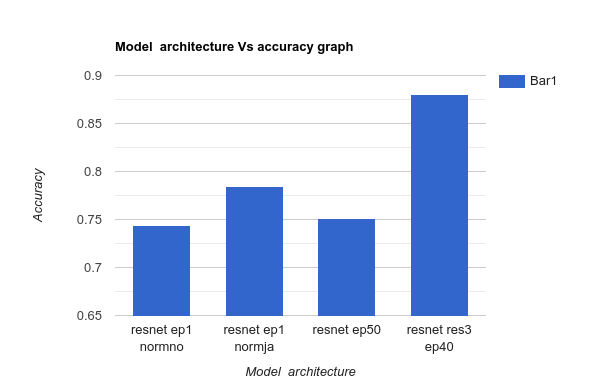